# Bio Neuro Project

### To improve

- Replace the -p for the end of exercise 1.3 by a better adaptation dynamic
- Change the plot of adptive behaviour in order to have correct stairs

In [1]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
import neurodynex3.tools.input_factory as input_factory
from Helpers import *
%load_ext autoreload
%autoreload 2

# Ex 1
## 1.1

We will simulate our neuron with no current to find the stable values of our parameters once the neuron has reached a stable state.

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    C:\Users\Merzo\Desktop\bio_465\BIO-465-project-main\BIO-465-project-main\Helpers.py:240: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[i].axis((
 [py.warnings]


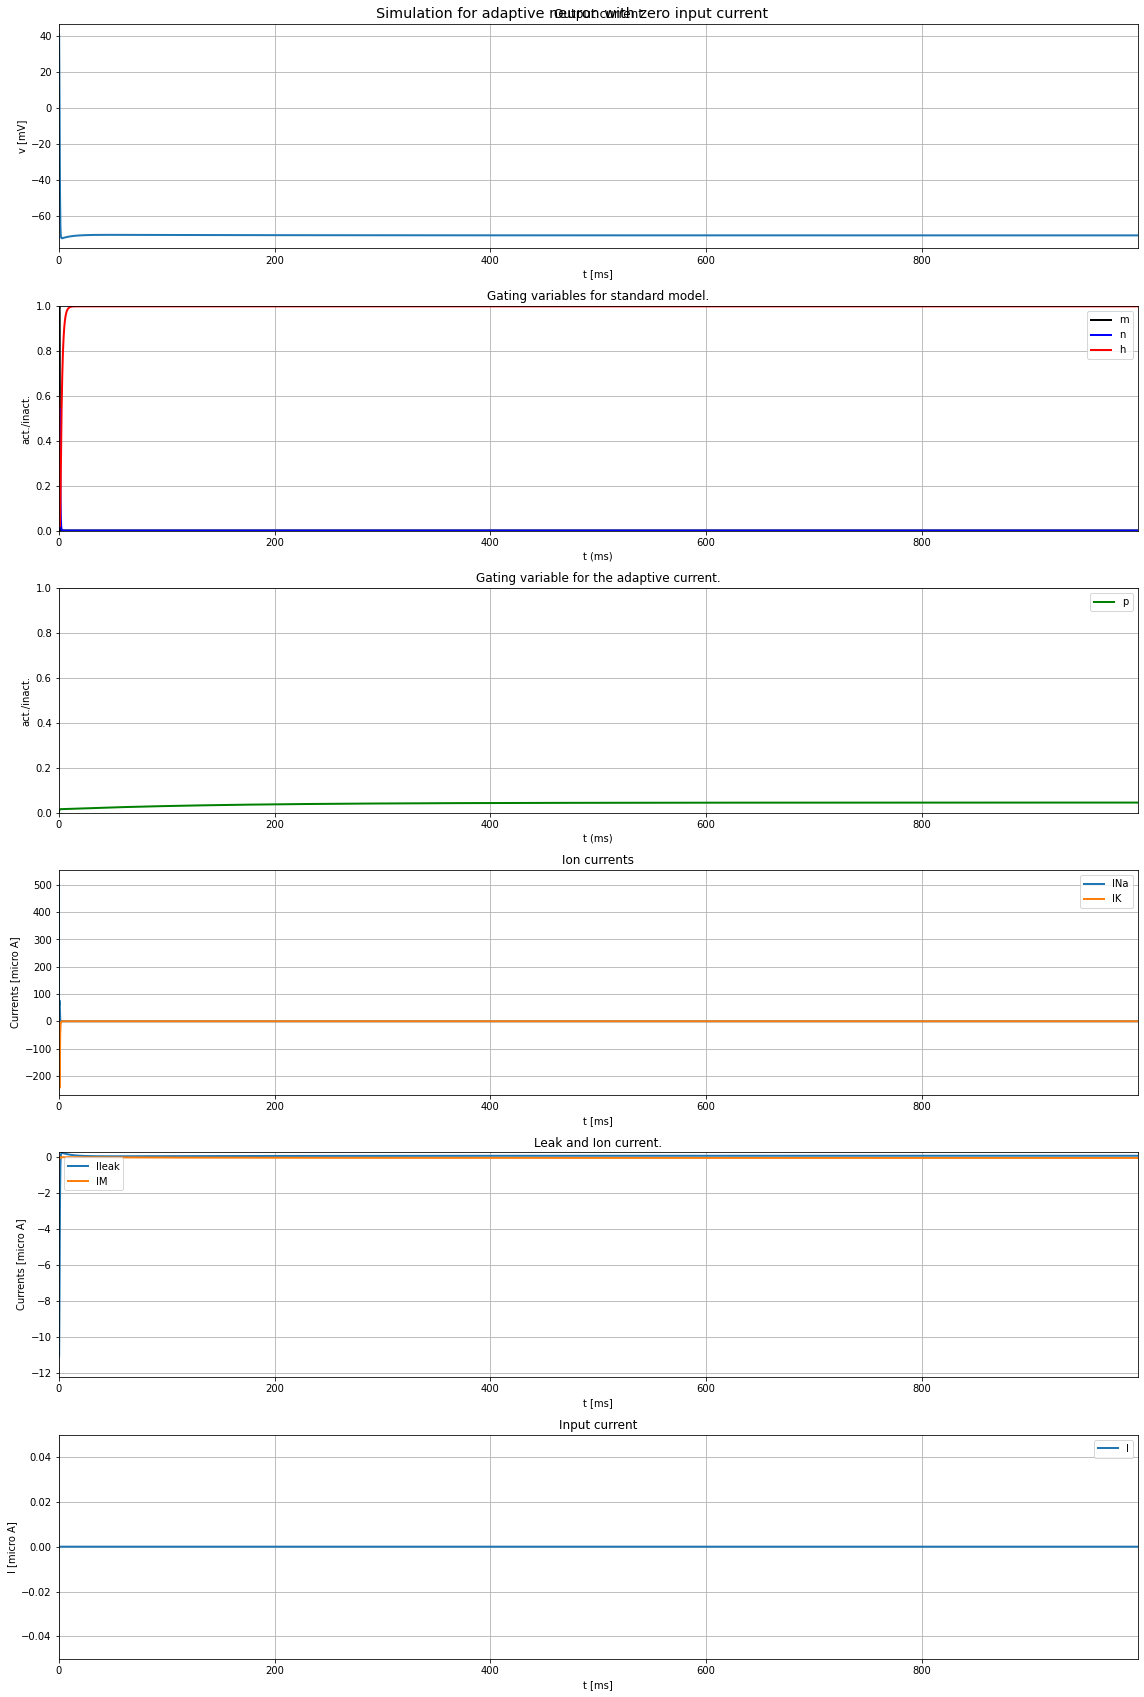

In [2]:
input_current = input_factory.get_zero_current()
state_monitor_stable_adaptive = simulate_adaptive_HH_neuron(input_current, 1000 * b2.ms)
plot_data(state_monitor_stable_adaptive,"Simulation for adaptive neuron with zero input current")

In [3]:
input_current = input_factory.get_zero_current()
state_monitor_stable_regular = simulate_regular_spiking_HH_neuron(input_current, 1000 * b2.ms)

We can now setup the values from the stable state for the following parameters:
- Resting potential $V_m$
- Gating variables $m,h,n,p$

In [4]:
regular_init = dict.fromkeys(["vm","m","h","n"])
adaptive_init = dict.fromkeys(["vm","m","h","n","p"])
for param, value in state_monitor_stable_adaptive.get_states().items():
    if param in adaptive_init:
        adaptive_init[param] = value[-1][0]
for param, value in state_monitor_stable_regular.get_states().items():
    if param in regular_init:
        regular_init[param] = value[-1][0]

In [63]:
regular_init

{'vm': -69.99971955 * mvolt,
 'm': 0.00167579367158219,
 'h': 0.9996835264465562,
 'n': 0.006540476106270621}

In [64]:
adaptive_init

{'vm': -70.6068853 * mvolt,
 'm': 0.0014597332213555506,
 'h': 0.9997289977134743,
 'n': 0.005843447953740352,
 'p': 0.04472168239976994}

## Spiking Behaviour

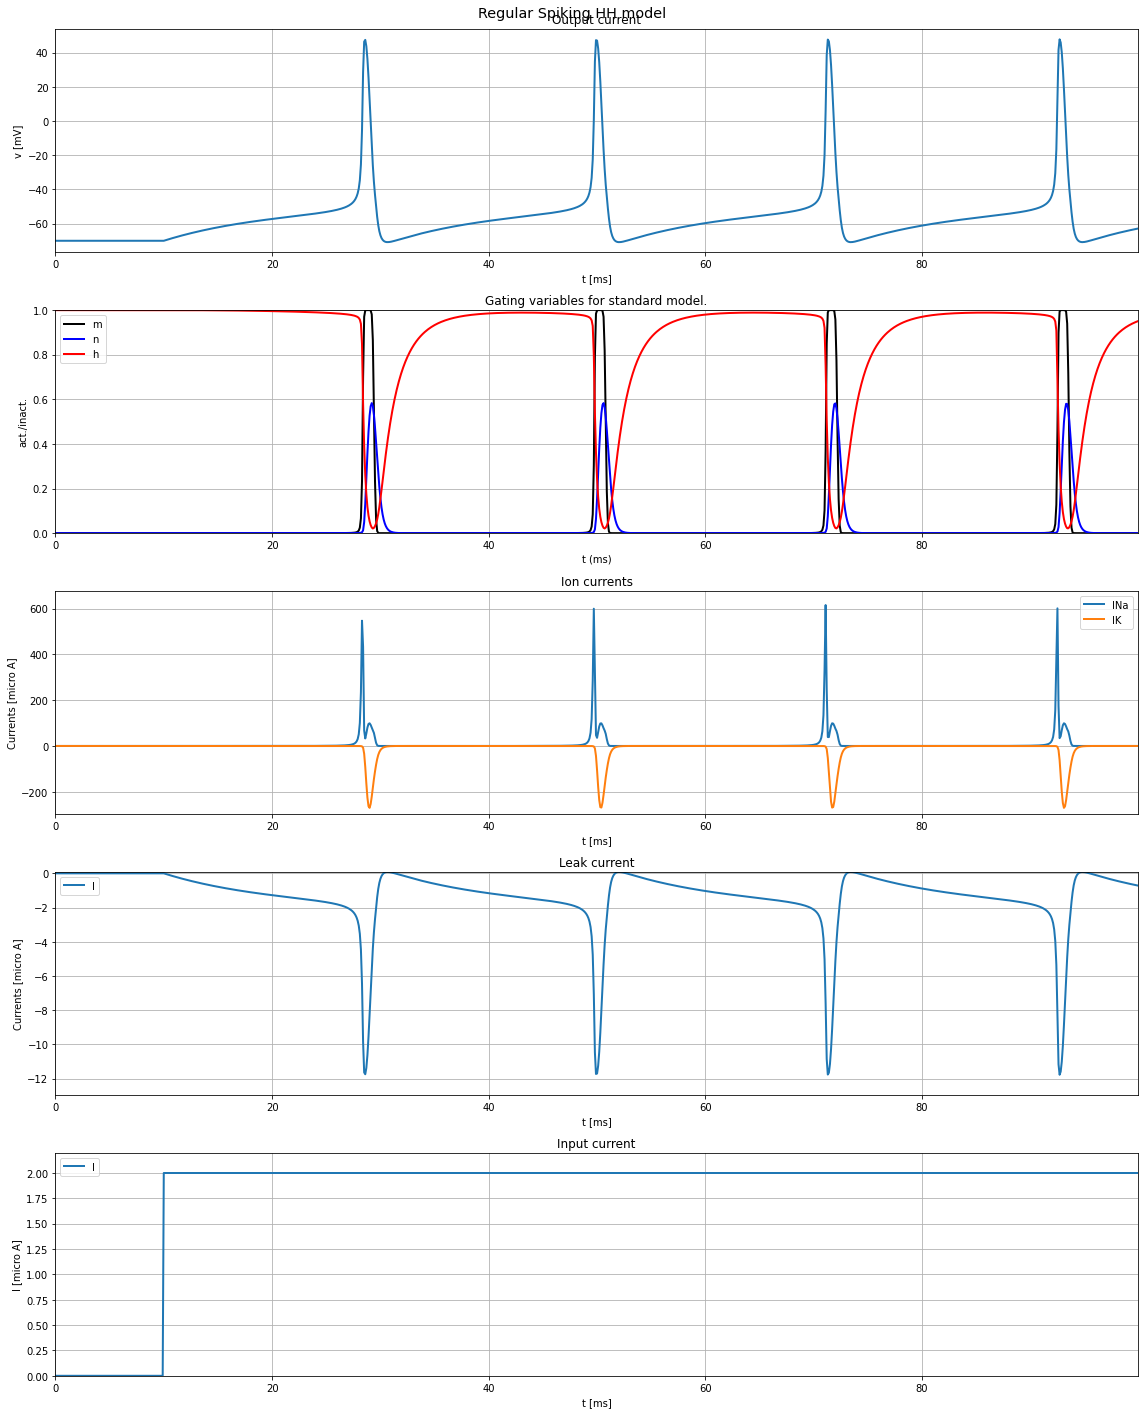

In [24]:
from Helpers import *
current = input_factory.get_step_current(10, 100, b2.ms, 2.0*b2.uA)
state_monitor = simulate_regular_spiking_HH_neuron(current, 100 * b2.ms, init_dict=regular_init)
plot_data(state_monitor, title="Regular Spiking HH model")

## 1.2

We will show that our regular spiking neuron model do not produce rebound spikes. For this we will use the same protocol as in the ex5, but show that no rebound occurs.

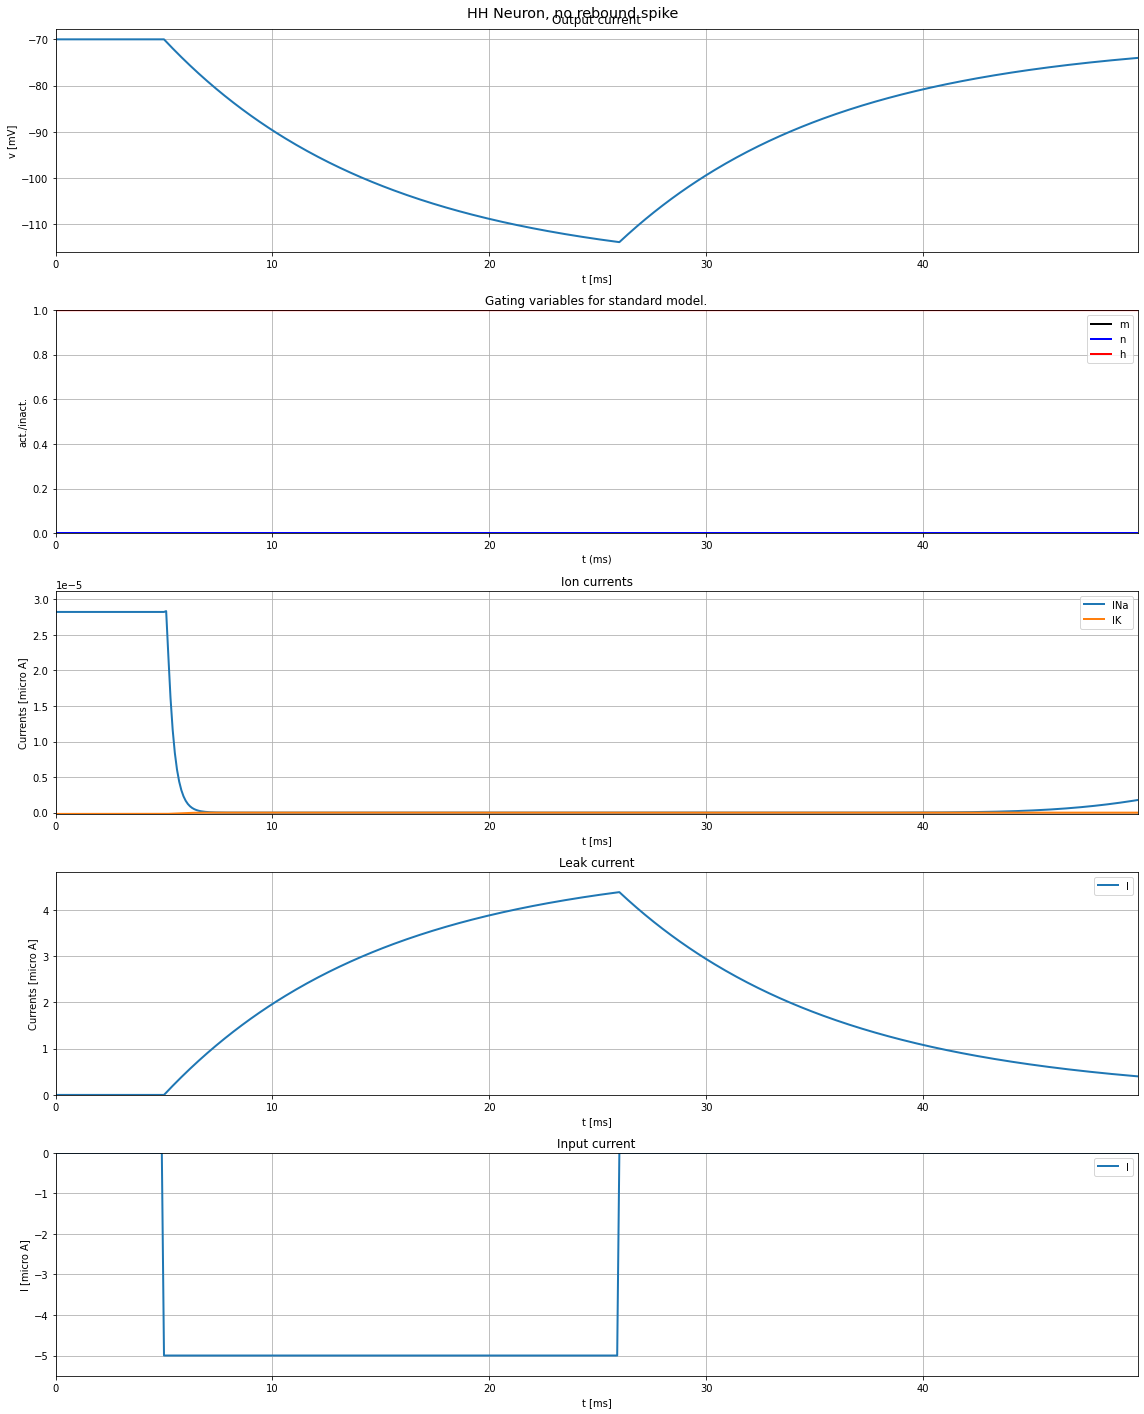

In [25]:
current = input_factory.get_step_current(5, 25, b2.ms, -5.*b2.uA)
state_monitor = simulate_regular_spiking_HH_neuron(current, 50 * b2.ms, init_dict= regular_init)
plot_data(state_monitor, title="HH Neuron, no rebound spike")

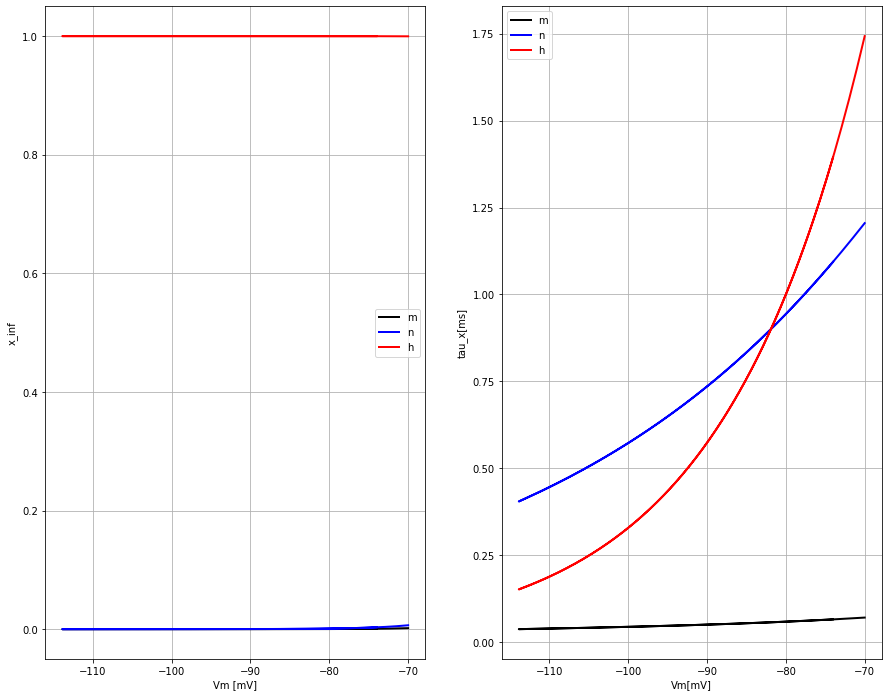

In [26]:

fig,ax = plt.subplots(1,2,figsize=(15,12))

ax[0].plot(state_monitor.vm[0] / b2.mV, state_monitor.m_inf[0] / b2.volt, "black", lw=2)
ax[0].plot(state_monitor.vm[0] / b2.mV, state_monitor.n_inf[0] / b2.volt, "blue", lw=2)
ax[0].plot(state_monitor.vm[0] / b2.mV, state_monitor.h_inf[0] / b2.volt, "red", lw=2)
ax[0].set_xlabel("Vm [mV]")
ax[0].set_ylabel("x_inf")
ax[0].legend(("m", "n", "h"))
ax[0].grid()

ax[1].plot(state_monitor.vm[0] / b2.mV, state_monitor.tau_m[0] / b2.ms, "black", lw=2)
ax[1].plot(state_monitor.vm[0] / b2.mV, state_monitor.tau_n[0] / b2.ms, "blue", lw=2)
ax[1].plot(state_monitor.vm[0] / b2.mV, state_monitor.tau_h[0] / b2.ms, "red", lw=2)
ax[1].set_xlabel("Vm[mV]")
ax[1].set_ylabel("tau_x[ms]")
ax[1].legend(("m", "n", "h"))
ax[1].grid()

We do not have a rebound spike because m and h have a smaller time scale difference than in the original setting. Thus whenever the hyperpolarizing current is stopped, we do not have a sufficient time where both h and m are non-zero to have a spike process.

# 1.3

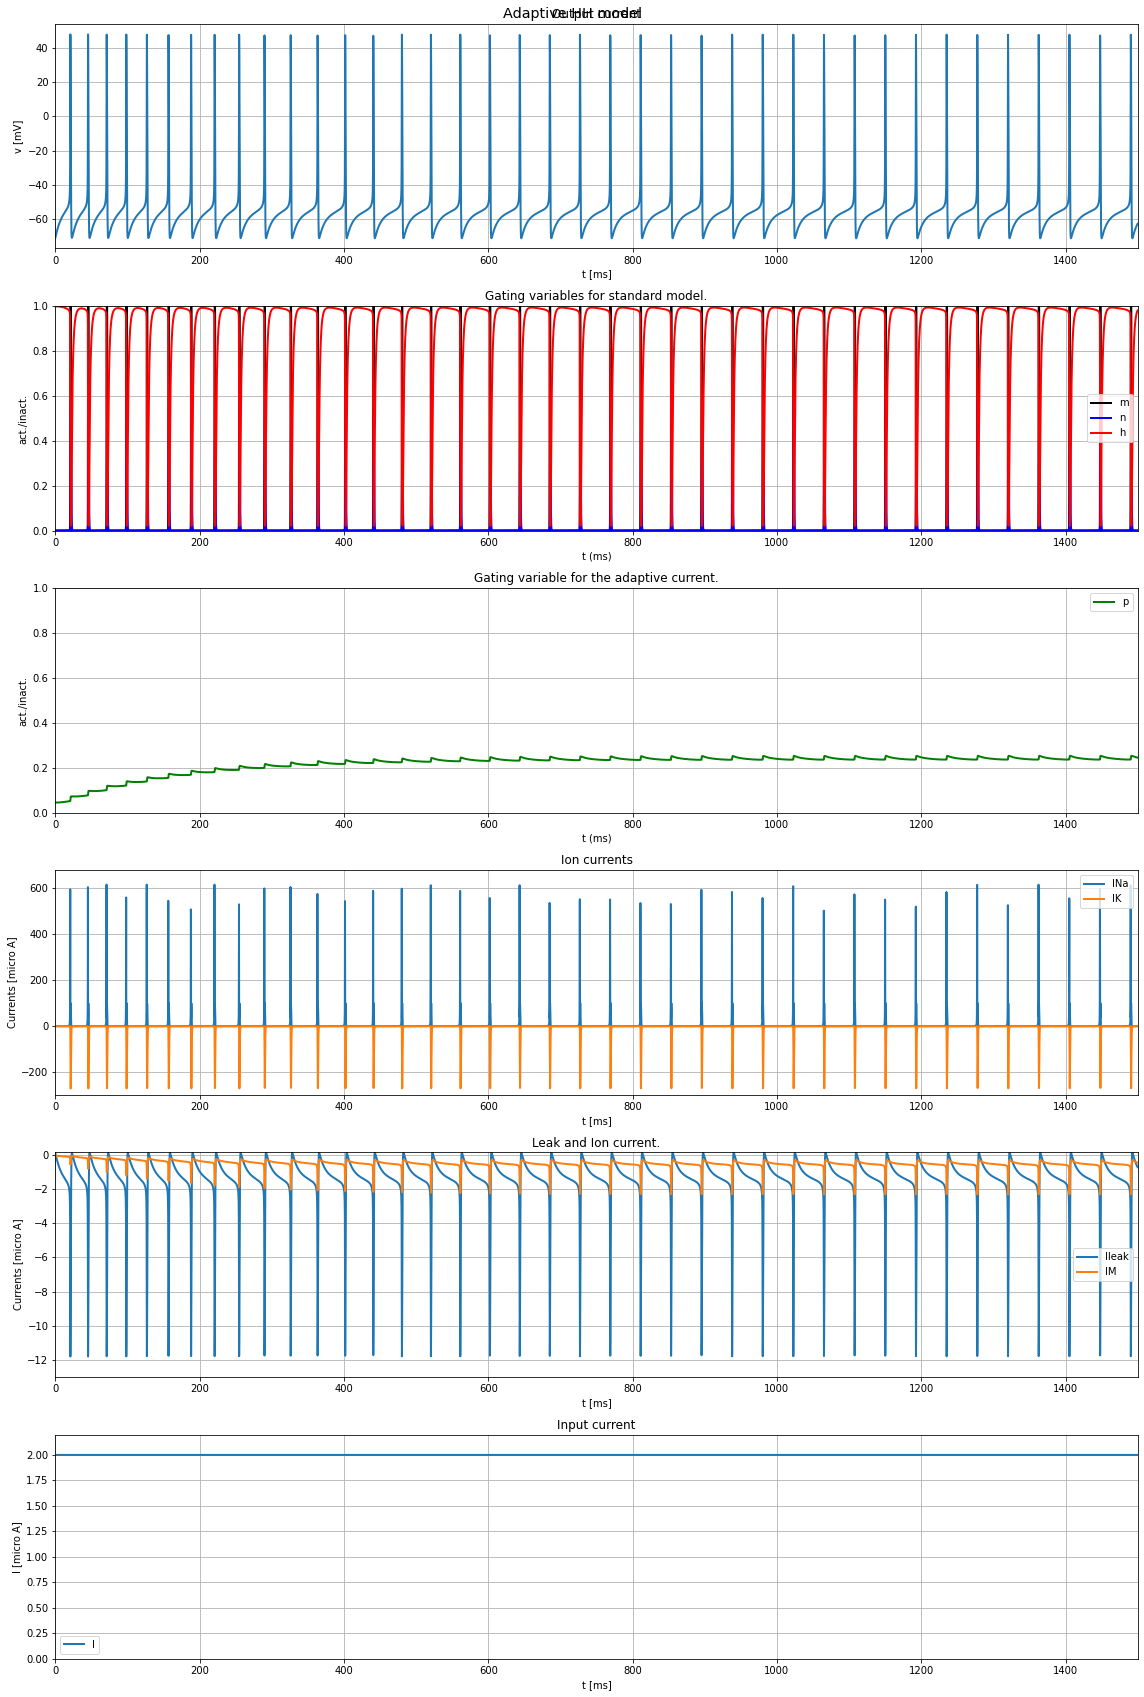

In [27]:
current = input_factory.get_step_current(0, 1500, b2.ms, 2.*b2.uA)
state_monitor = simulate_adaptive_HH_neuron(current, 1500 * b2.ms, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model")

- The new channel $I_m$ will slow the firing rate. The channels open each time that we have a spike and deactivate over a longer period than interval between spikes. Thus after multiple spikes, the partial activation of the $I_m$ channels will accumulate, reducing the membrage potential. This acts as a longer refractoriness period and thus making it harder to fire.
- $p$ is increasing until it reaches a stable plateau around 0.25. We can see the step behaviour due to a inactivation time greater than the inter spike interval.
- $p$ acts in a similar way as n for the potassium channel $I_K$. At its resting value it is set to 0, the channel is closed. But whenever we pass a voltage threshold, p increases and the channel (partially) opens.

### Adaptive Behaviour

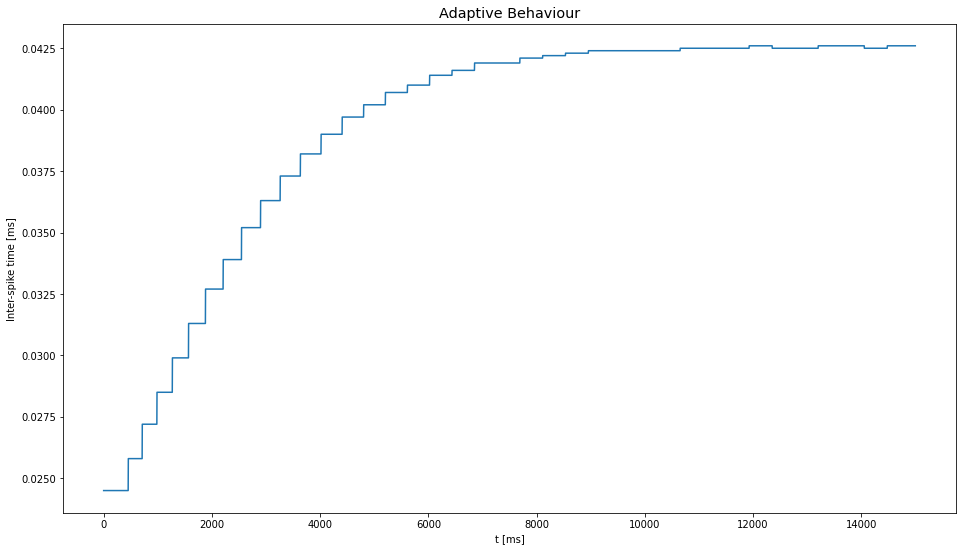

In [28]:
plot_adaptive_behaviour(state_monitor)

The upper figure shows the adaptative behaviour of our neuron. On the x axis we have the time elpased during the simulation, and on the y axis we can find the inter spike time, i.e. the time in ms between two spikes. For a regular spiking neuron, this curve would be almost flat (fluctuations can occur due to noise and time discretization). But here we clearly see that the inter spike time increase, thus the neuron fires less often.

#### Slow down the adaptation rate ($\tau_p'=2\tau_p$)

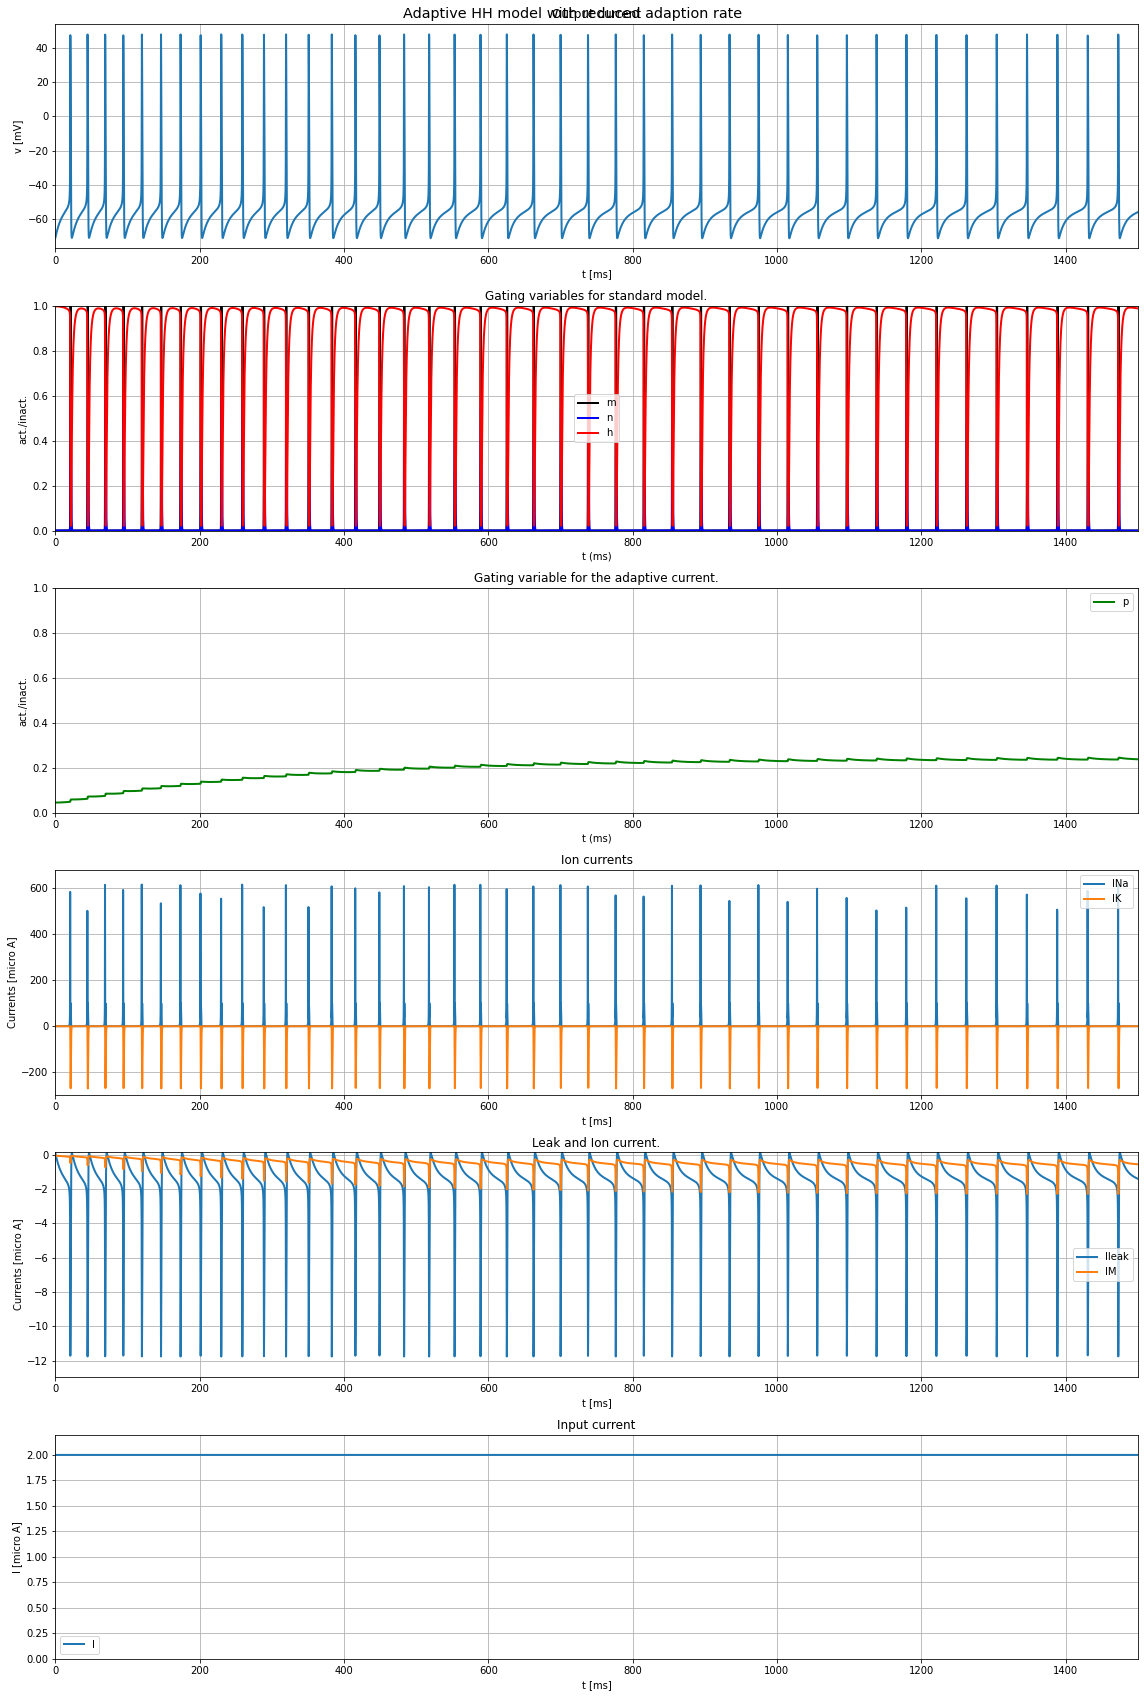

In [50]:
from Helpers import *
current = input_factory.get_step_current(0, 1500, b2.ms, 2.*b2.uA)
state_monitor = simulate_adaptive_HH_neuron(current, 1500 * b2.ms, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model with reduced adaption rate")

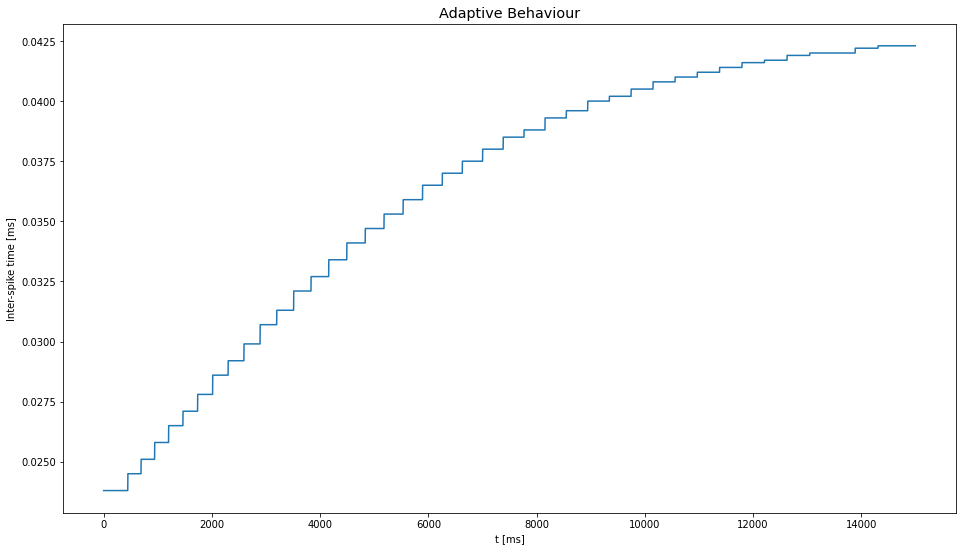

In [51]:
plot_adaptive_behaviour(state_monitor)

####  Decrease the stable firing rate ($p'=\frac{p}{2}$)

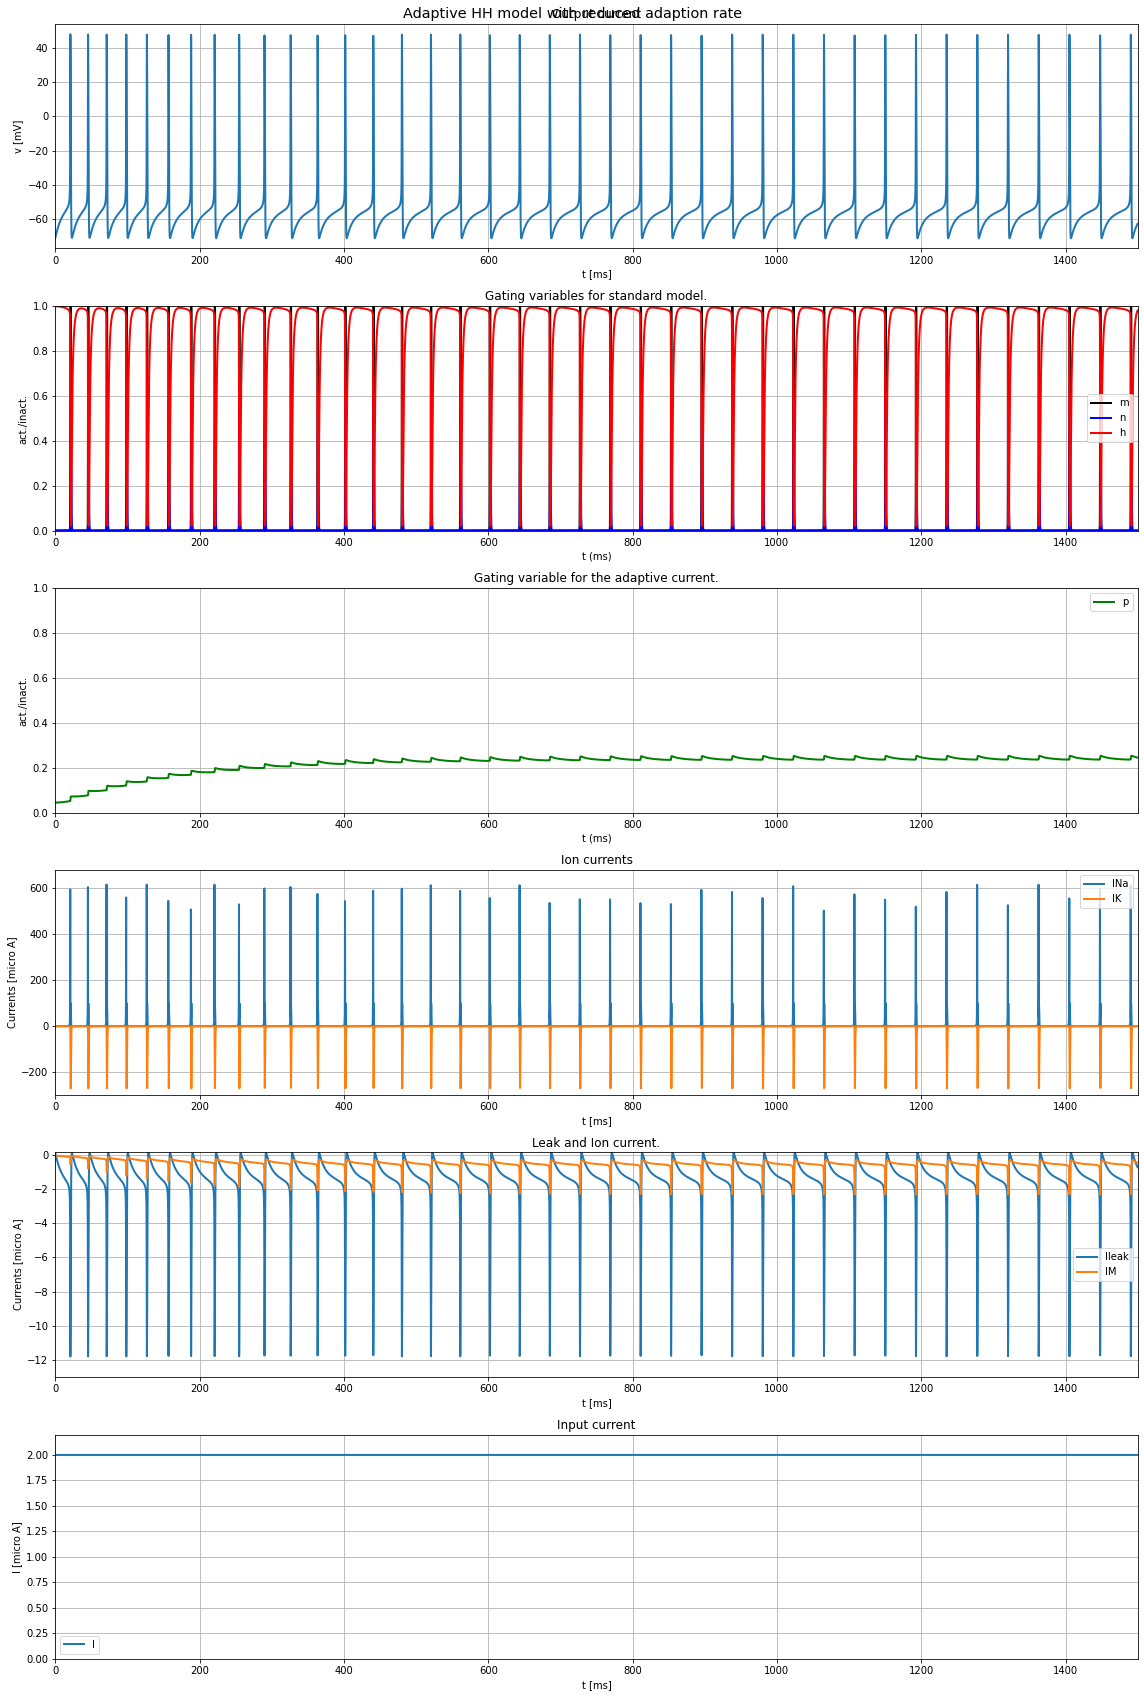

In [54]:
from Helpers import *
current = input_factory.get_step_current(0, 1500, b2.ms, 2.*b2.uA)
state_monitor = simulate_adaptive_HH_neuron(current, 1500 * b2.ms, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model with reduced adaption rate")

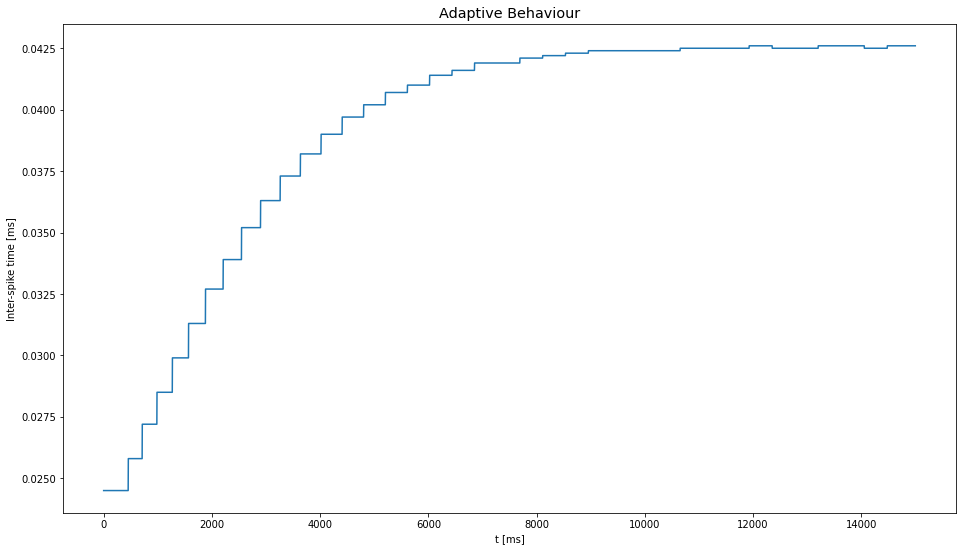

In [55]:
plot_adaptive_behaviour(state_monitor)

#### Reverse adaptation ($p_\infty'=-p_\infty$)

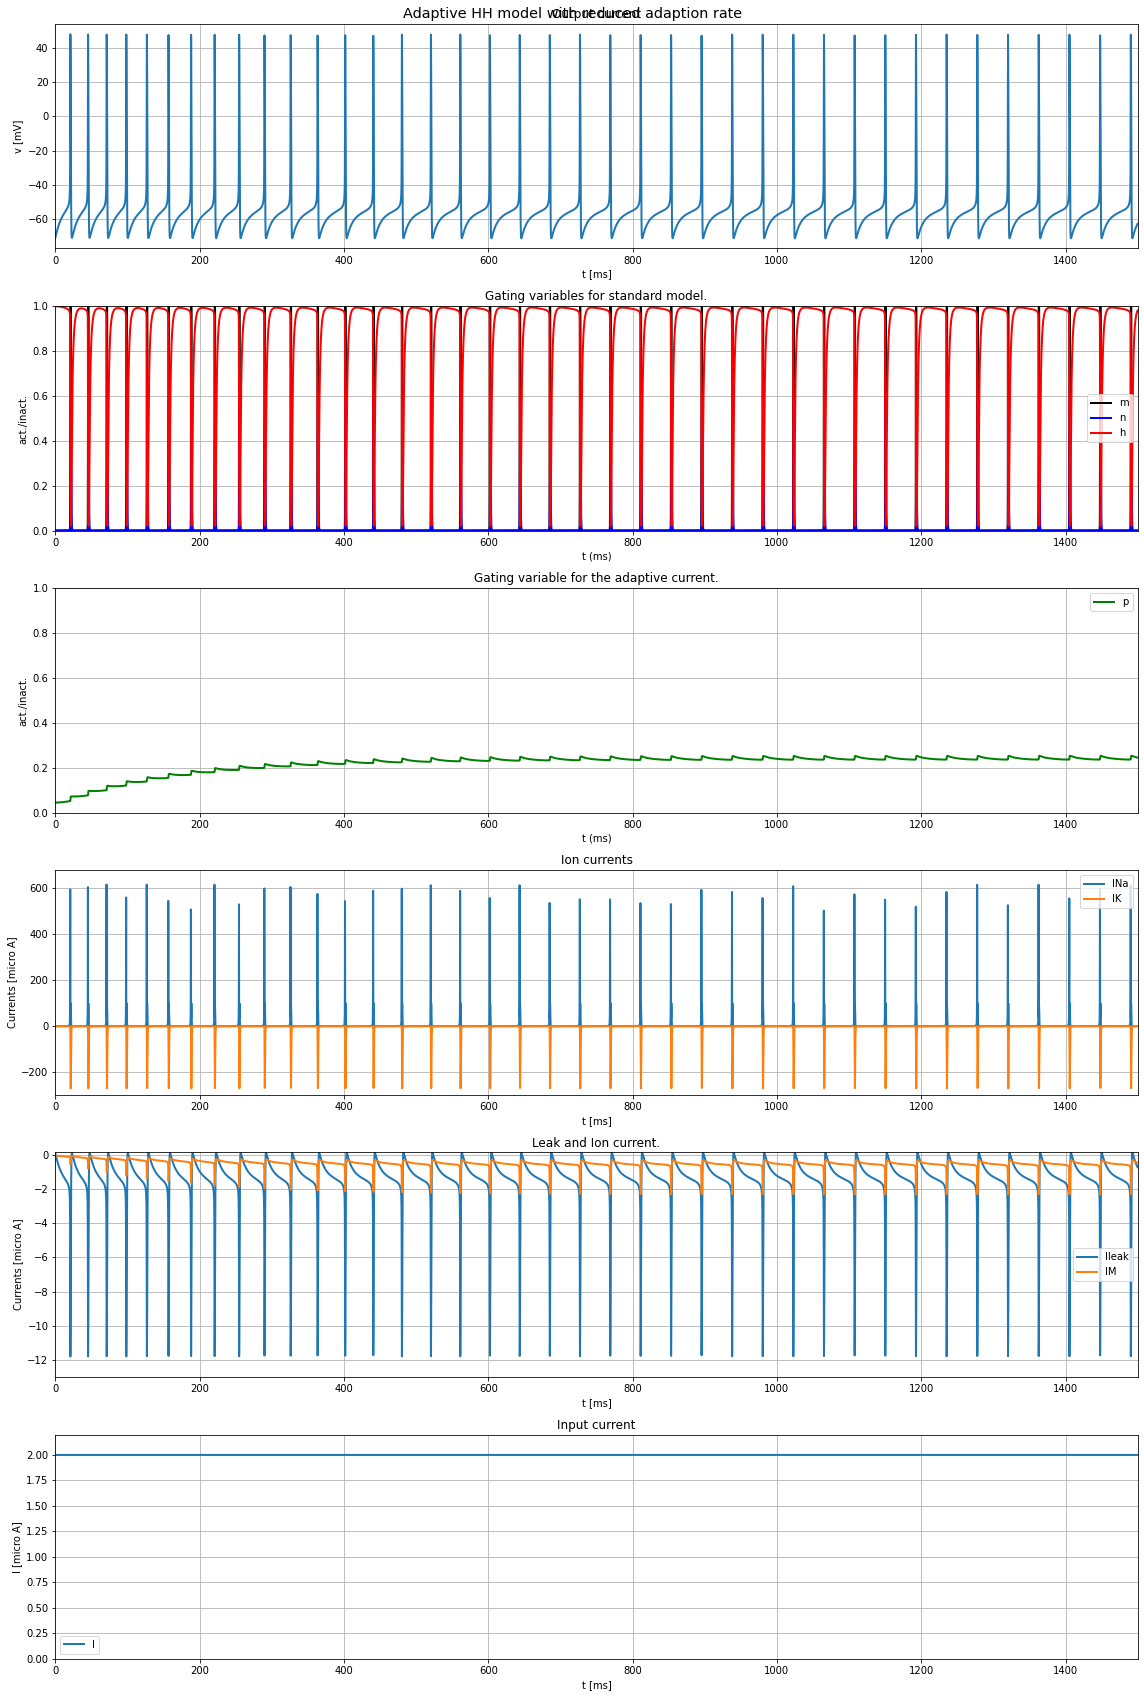

In [56]:
from Helpers import *
current = input_factory.get_step_current(0, 1500, b2.ms, 2.*b2.uA)
state_monitor = simulate_adaptive_HH_neuron(current, 1500 * b2.ms, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model with reduced adaption rate")

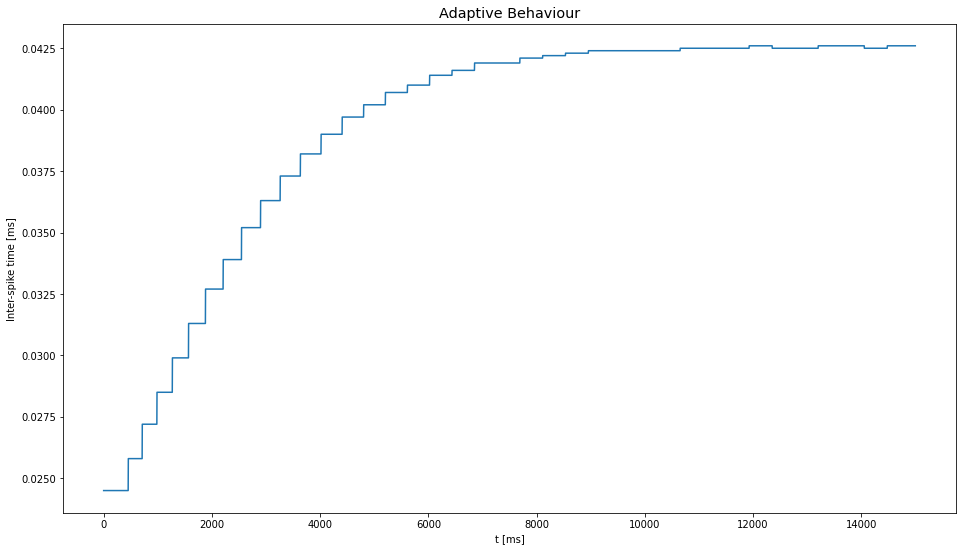

In [57]:
plot_adaptive_behaviour(state_monitor)

## Ex 2

## 2.1

Here are the way to get the parameters:
- Resting potential $V_{rest}=E_l$, put zero current and read the stable potential --> $V_rest = -70.6073$
- Passive membrane resistance $R$, put delta current and divide the difference of voltage occured divided by the input current: $\frac{v_{max}-v_{rest}}{I_{injected}}$ --> $R = 99527$
- Passive membrane time constant $\tau_m$, set as the time to reach 63% of the max voltage --> $\tau_m = 0.63.10^{-3}$ 
 
Working with the equations of AdEx we can see that: $g_l=1/R$ and $C=\tau_mg_l$

- Using the above expression, $g_l=0.00001$
- Using the above expression, $C=0.63.10^{-9}$

In [5]:
adaptive_init

{'vm': -70.6068853 * mvolt,
 'm': 0.0014597332213555506,
 'h': 0.9997289977134743,
 'n': 0.005843447953740352,
 'p': 0.04472168239976994}

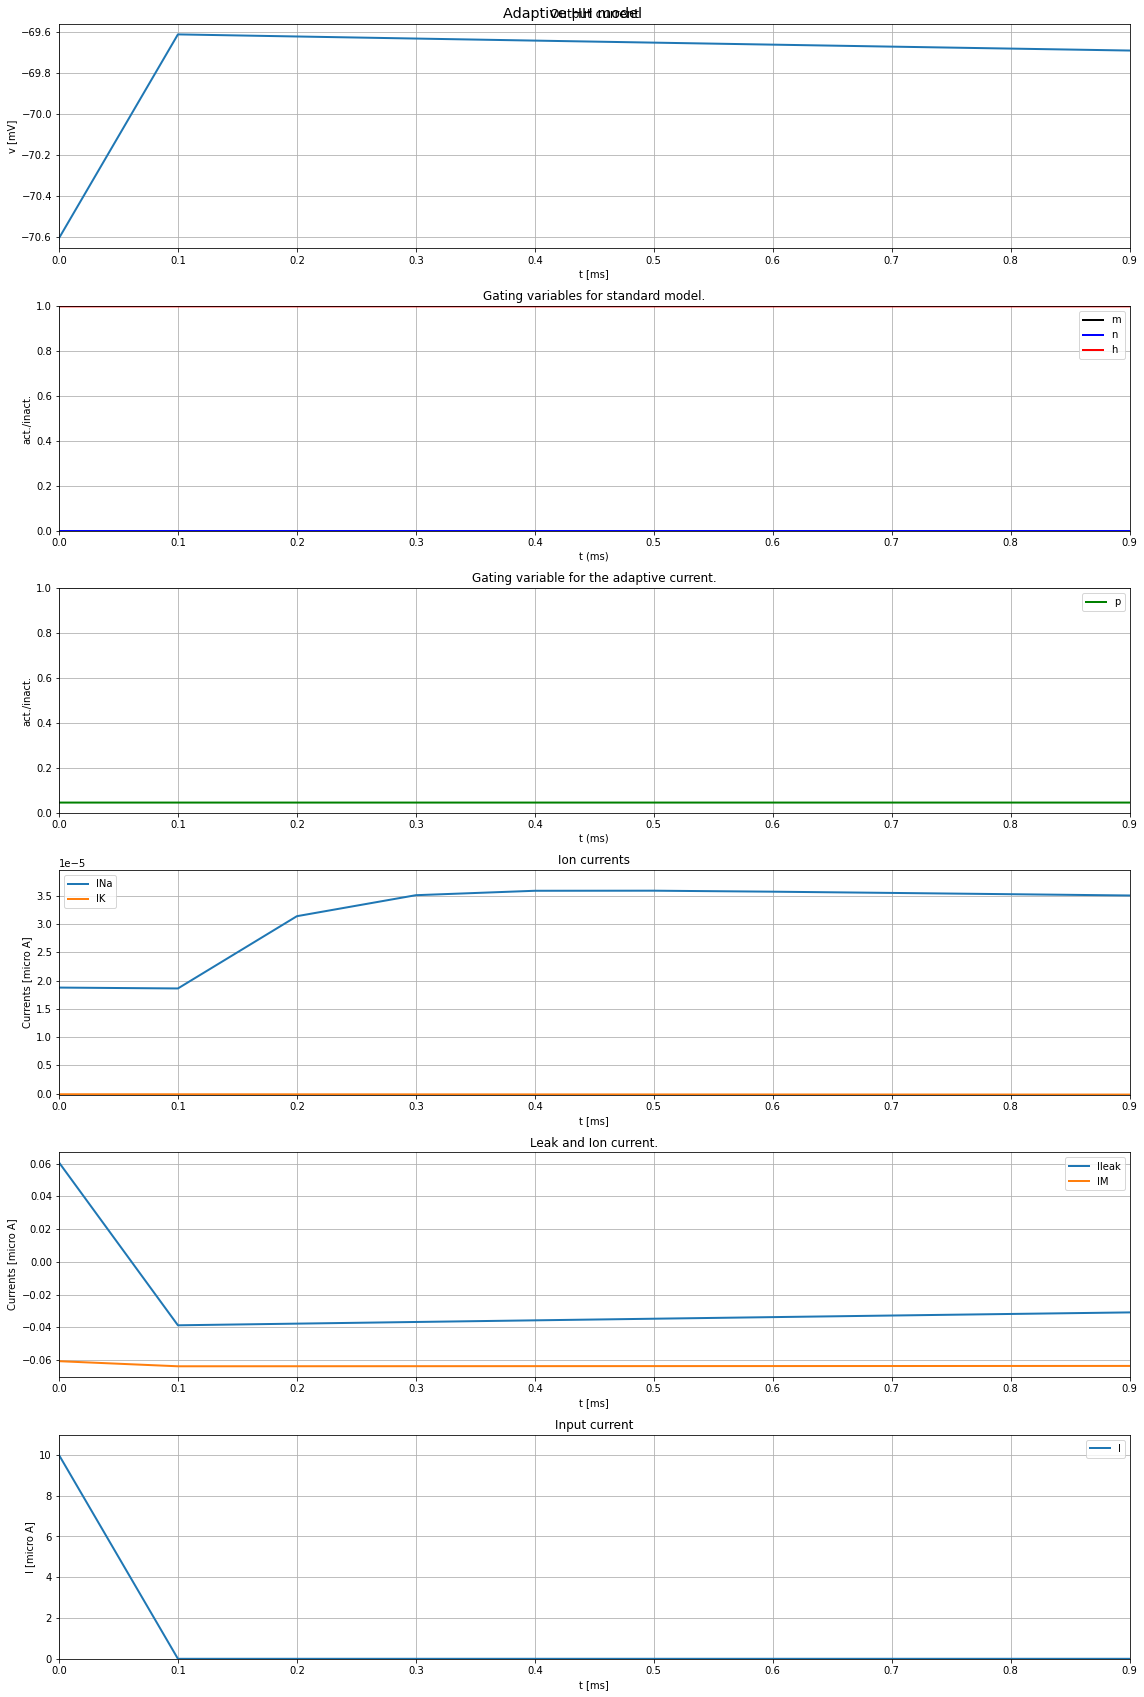

In [10]:
current = input_factory.get_step_current(0, 10, b2.us, 10.*b2.uA)
state_monitor = simulate_adaptive_HH_neuron(current, 1000 * b2.us, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model")

In [11]:
V_max = max(state_monitor.get_states()["vm"])
V_max

array([-69.61202448]) * mvolt

## 2.2

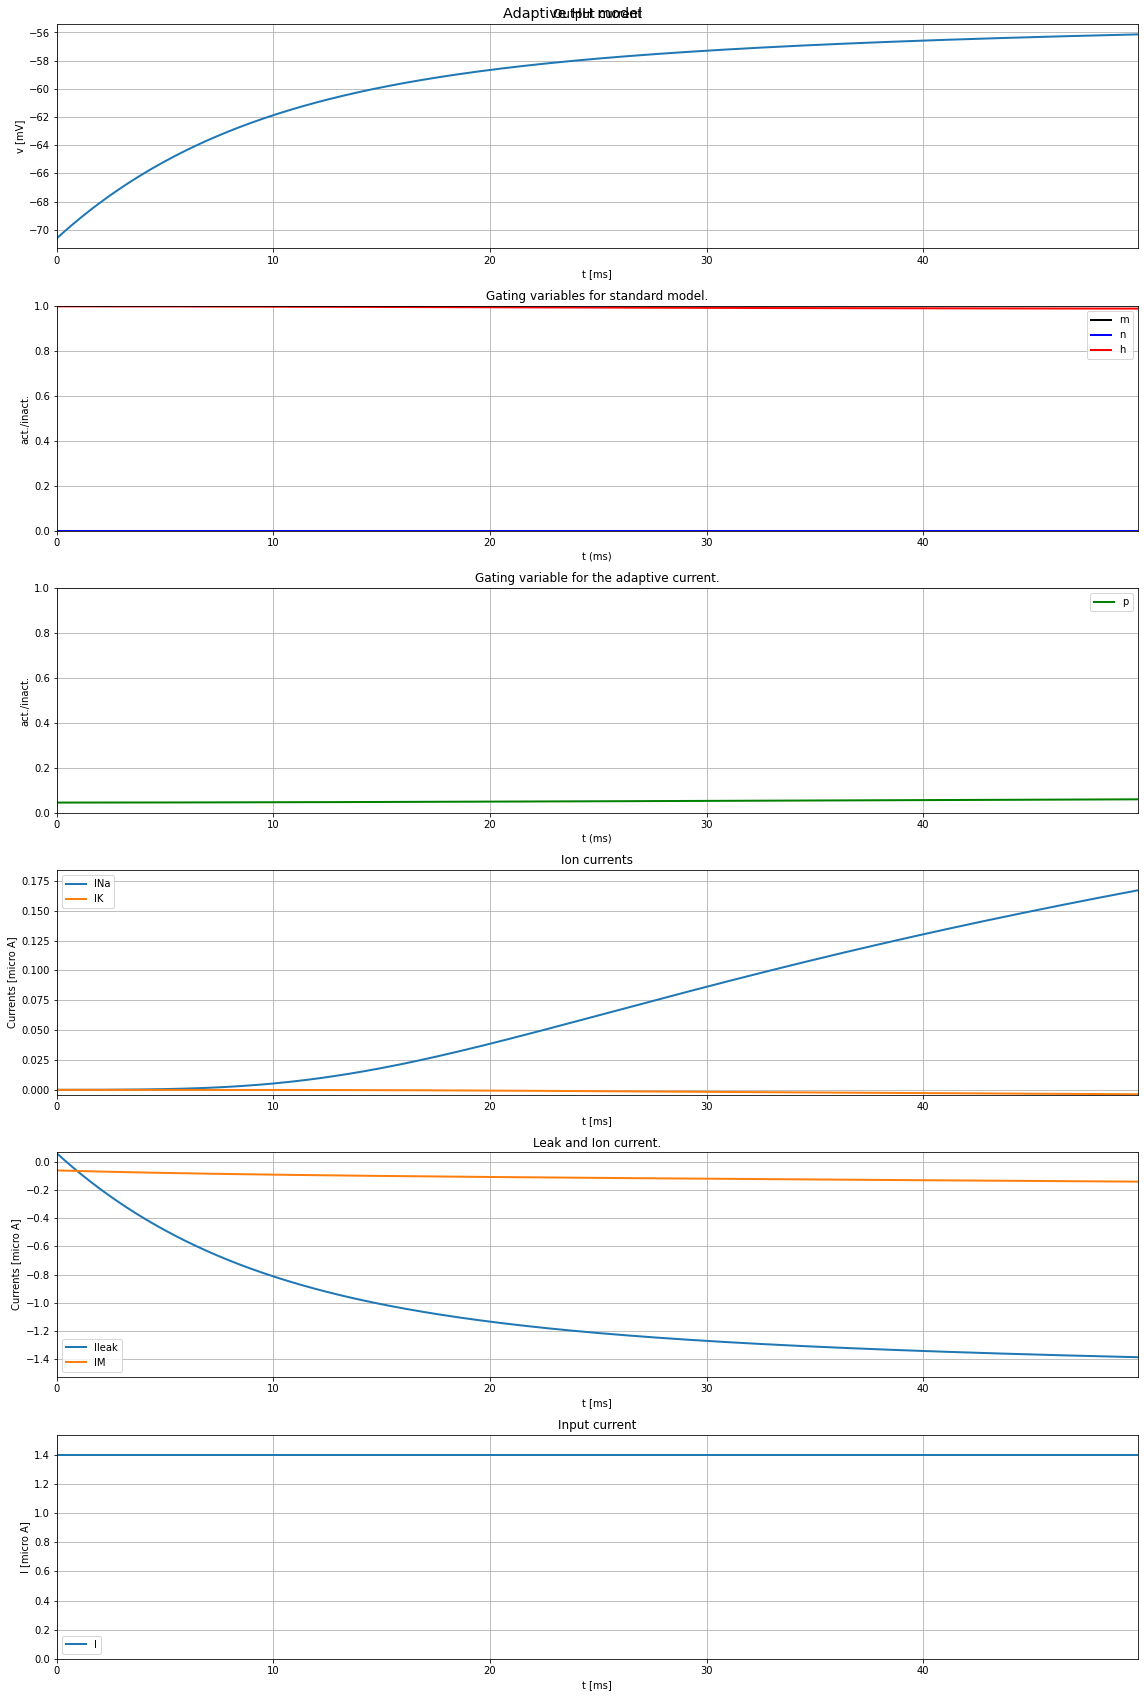

In [59]:
current = input_factory.get_step_current(0, 50, b2.ms, 1.4*b2.uA)
state_monitor = simulate_adaptive_HH_neuron(current, 50 * b2.ms, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model")

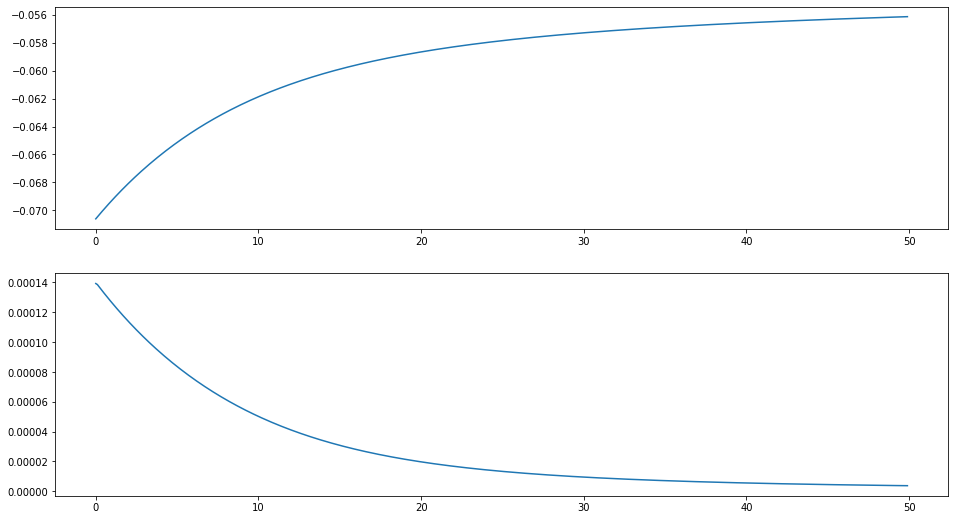

In [47]:
fig,ax = plt.subplots(2,1,figsize=(16,9))
ax[0].plot(state_monitor.get_states()["t"]*1000,state_monitor.get_states()["vm"][:,0])
ax[1].plot(state_monitor.get_states()["t"]*1000,np.gradient(state_monitor.get_states()["vm"][:,0]))

#### $\Delta_T$, max current before spiking : 197 micro Ampere

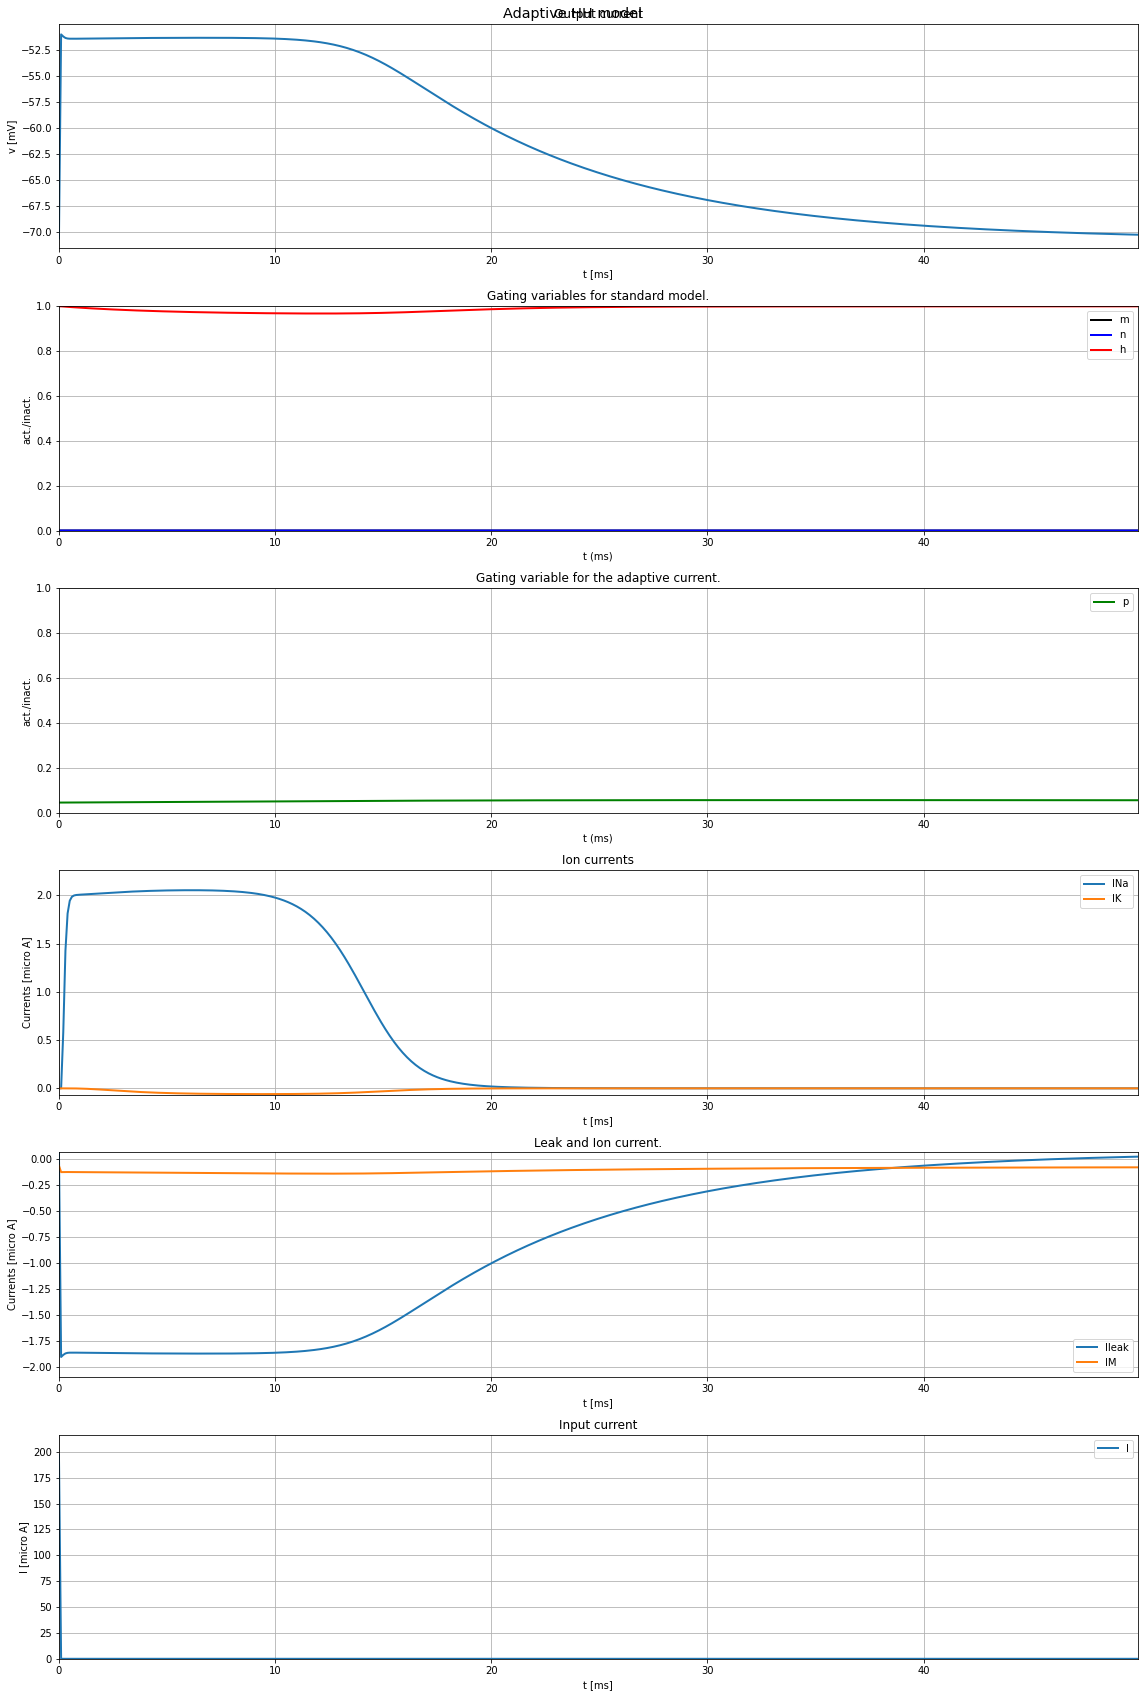

In [7]:
current = input_factory.get_step_current(0, 1, b2.us, 1.4*b2.uA)
state_monitor = simulate_adaptive_HH_neuron(current, 50 * b2.ms, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model")

In [48]:
Vs = max(state_monitor.get_states()["vm"])
Vs

array([-56.13480729]) * mvolt

We get Vs because any point above it would lead to an unstable point where the voltage value will rise to the maximum and then will be reset.

In [6]:
gl = 0.00001
El = -70.6073e-3
rheo = -56e-3
Vs = -56.1348072854536e-3
def func_vs(x):
    return -(Vs-El) + x*np.exp((Vs-rheo)/x)

In [91]:
from scipy.optimize import fsolve
fsolve(func_vs, 0.0001)

array([0.01460668])

In [60]:
func_vs(fsolve(func_vs, 0.002))

array([2.64697796e-23])

In [84]:
np.isclose(func_vs(fsolve(func_vs, 0.002)), 0) 

array([ True])

### 2.3

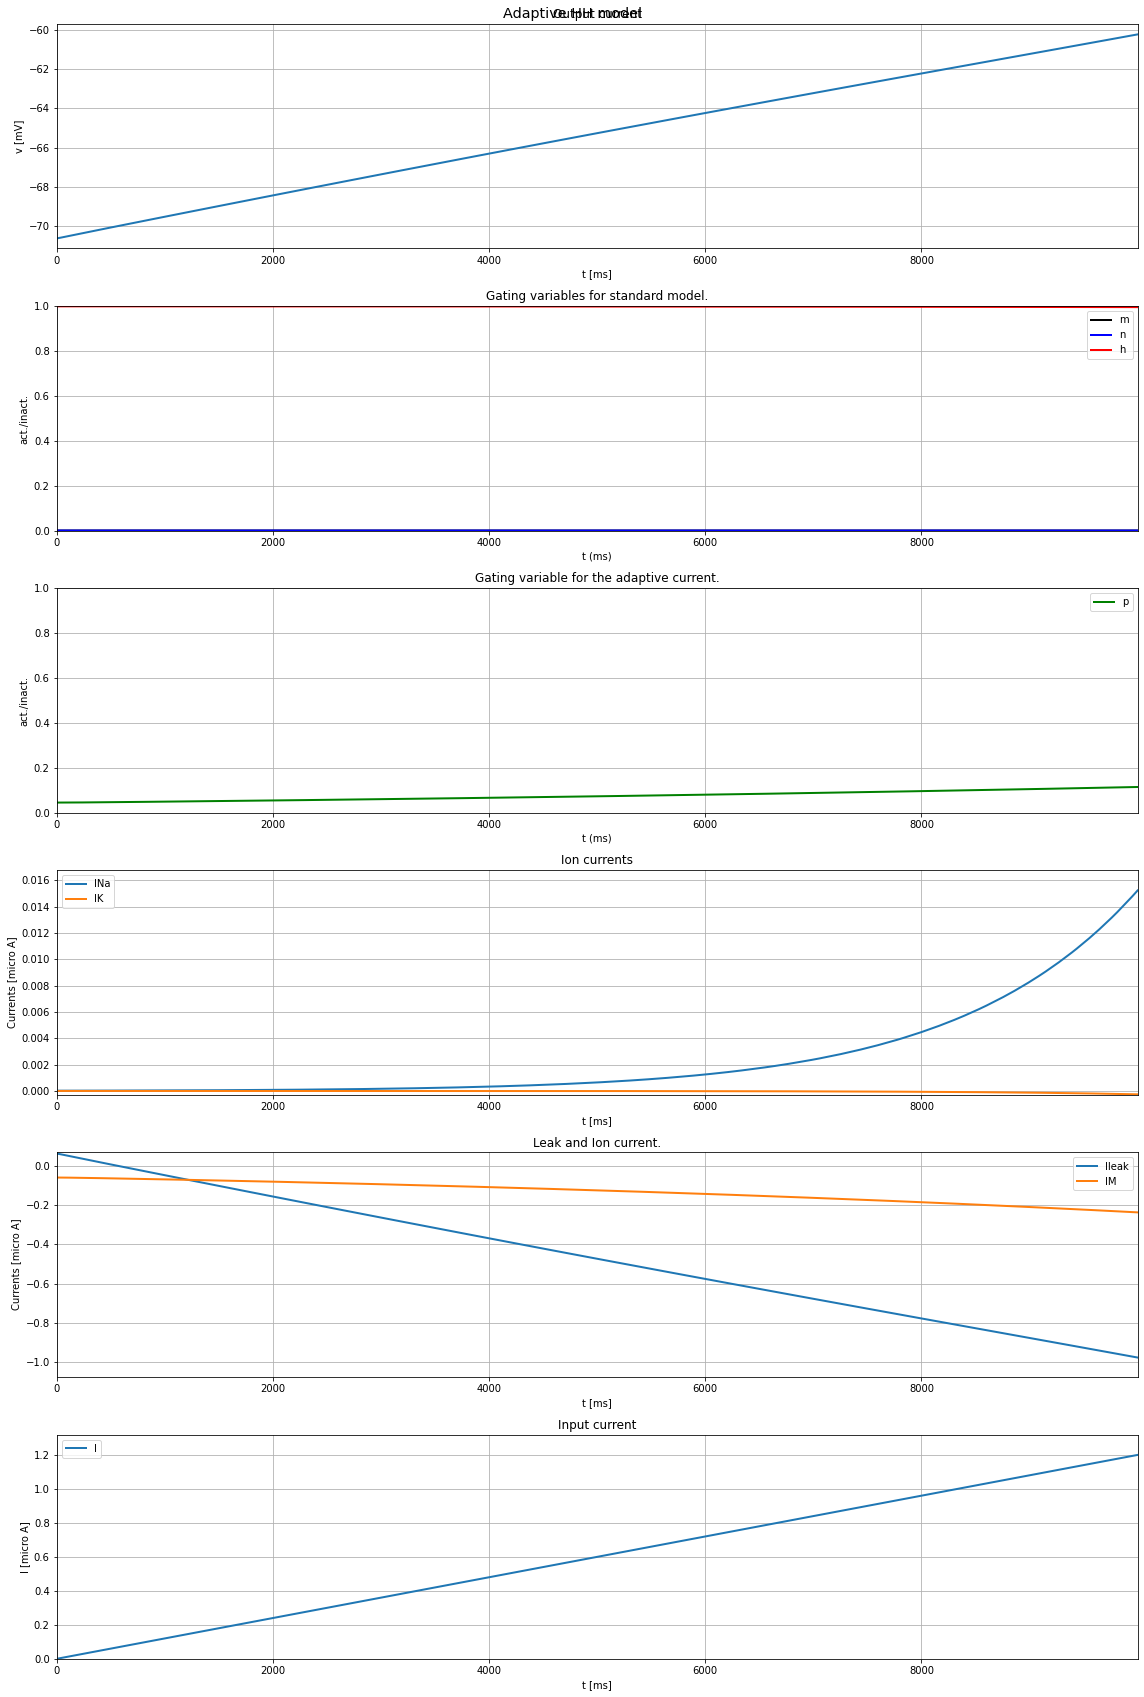

In [7]:
current = input_factory.get_ramp_current(0, 10000, b2.ms, 0*b2.uA, 1.2*b2.uA)
state_monitor = simulate_adaptive_HH_neuron(current, 10000 * b2.ms, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model")

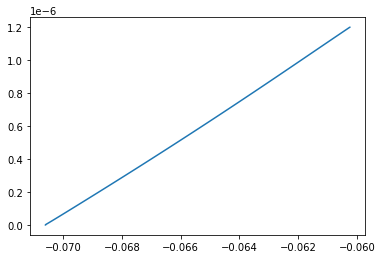

In [8]:
plt.plot(state_monitor.get_states()["vm"],state_monitor.get_states()["I_e"])

Using the different time scale approximations, we can set up that the slope in the I-V curve is given by $(a+g_l)$. Thus we can compute the slope and substract $g_l$ to extract the coupling parameter.

In [14]:
a = float(state_monitor.get_states()["I_e"][-1,0])/float(state_monitor.get_states()["vm"][-1,0])- gl
a

-2.9918387691443707e-05

In [12]:
float(state_monitor.get_states()["I_e"][-1,0])

1.19988e-06

## 2.4

nr of spikes: 73


(<AxesSubplot:ylabel='Input current [A] \n min: 2e-06 \nmax: 2e-06'>,
 <AxesSubplot:xlabel='t [ms]', ylabel='membrane voltage [mV]\n min: -0.07606778710684556\n max: 0.029220967192663618'>)

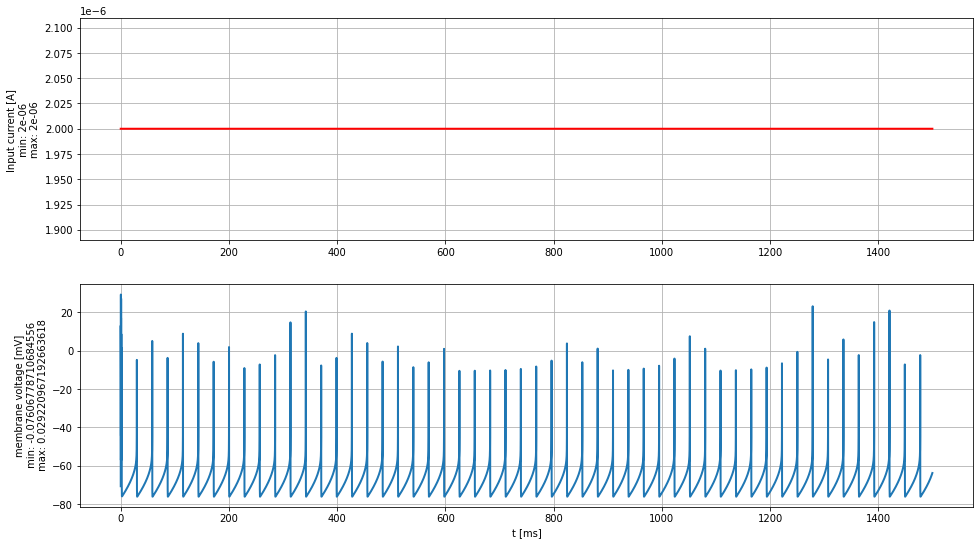

In [16]:
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import plot_tools

current = input_factory.get_step_current(0, 1500, b2.ms, 2.*b2.uA)
state_monitor, spike_monitor = AdEx.simulate_AdEx_neuron( tau_m=0.063*b2.ms,
                                        R=0.099527 *b2.Mohm, v_rest=-70.60*b2.mV , v_rheobase=-56*b2.mV, a=For this part * b2.nS, v_spike=30*b2.mV, delta_T=14.6*b2.mV ,
                                        b=100000 * b2.pA, tau_w=600*b2.ms, v_reset= -57 * b2.mV,
                                        I_stim=current,simulation_time=1500 * b2.ms)
print("nr of spikes: {}".format(spike_monitor.count[0]))
fig,ax = plt.subplots(figsize=(16,9))
plot_tools.plot_voltage_and_current_traces(state_monitor, current)


In [17]:
#plot_adex_state(state_monitor)

# 2.5

In [28]:
np.random.seed(19)
I_ext = 1*b2.uA + 15*b2.uA * np.random.randn()
I_ext

4.31504894 * uamp

nr of spikes: 81


(<AxesSubplot:ylabel='Input current [A] \n min: 4.315048940232234e-06 \nmax: 4.315048940232234e-06'>,
 <AxesSubplot:xlabel='t [ms]', ylabel='membrane voltage [mV]\n min: -0.07540963951661578\n max: 0.02932466829201725'>)

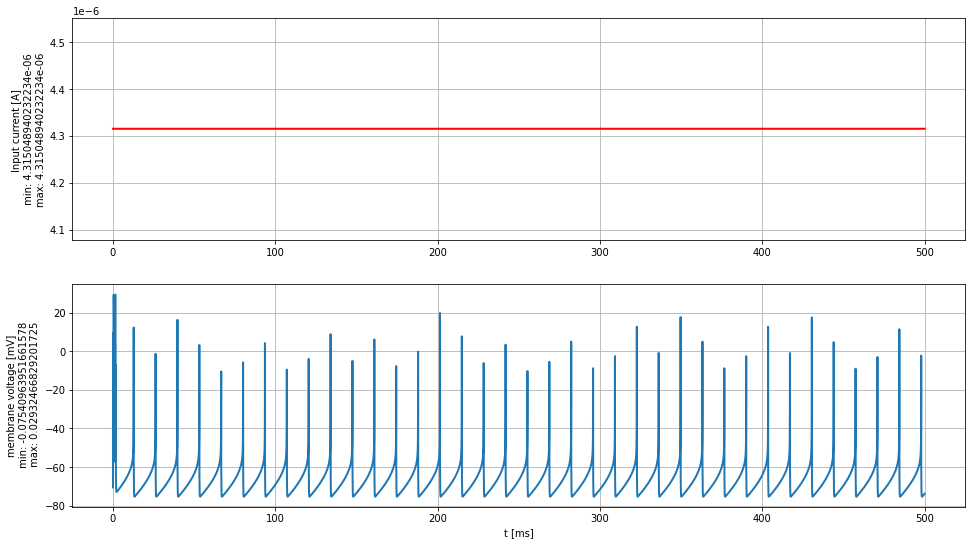

In [57]:
current = input_factory.get_step_current(0, 500, b2.ms, I_ext)
state_monitor, spike_monitor = AdEx.simulate_AdEx_neuron( tau_m=0.063*b2.ms,
                                        R=0.099527 *b2.Mohm, v_rest=-70.60*b2.mV , v_rheobase=-56*b2.mV, a=-29920 * b2.nS, v_spike=30*b2.mV, delta_T=14.6*b2.mV ,
                                        b=100000 * b2.pA, tau_w=600*b2.ms, v_reset= -57 * b2.mV,
                                        I_stim=current,simulation_time=500 * b2.ms)
print("nr of spikes: {}".format(spike_monitor.count[0]))
fig,ax = plt.subplots(figsize=(16,9))
plot_tools.plot_voltage_and_current_traces(state_monitor, current)

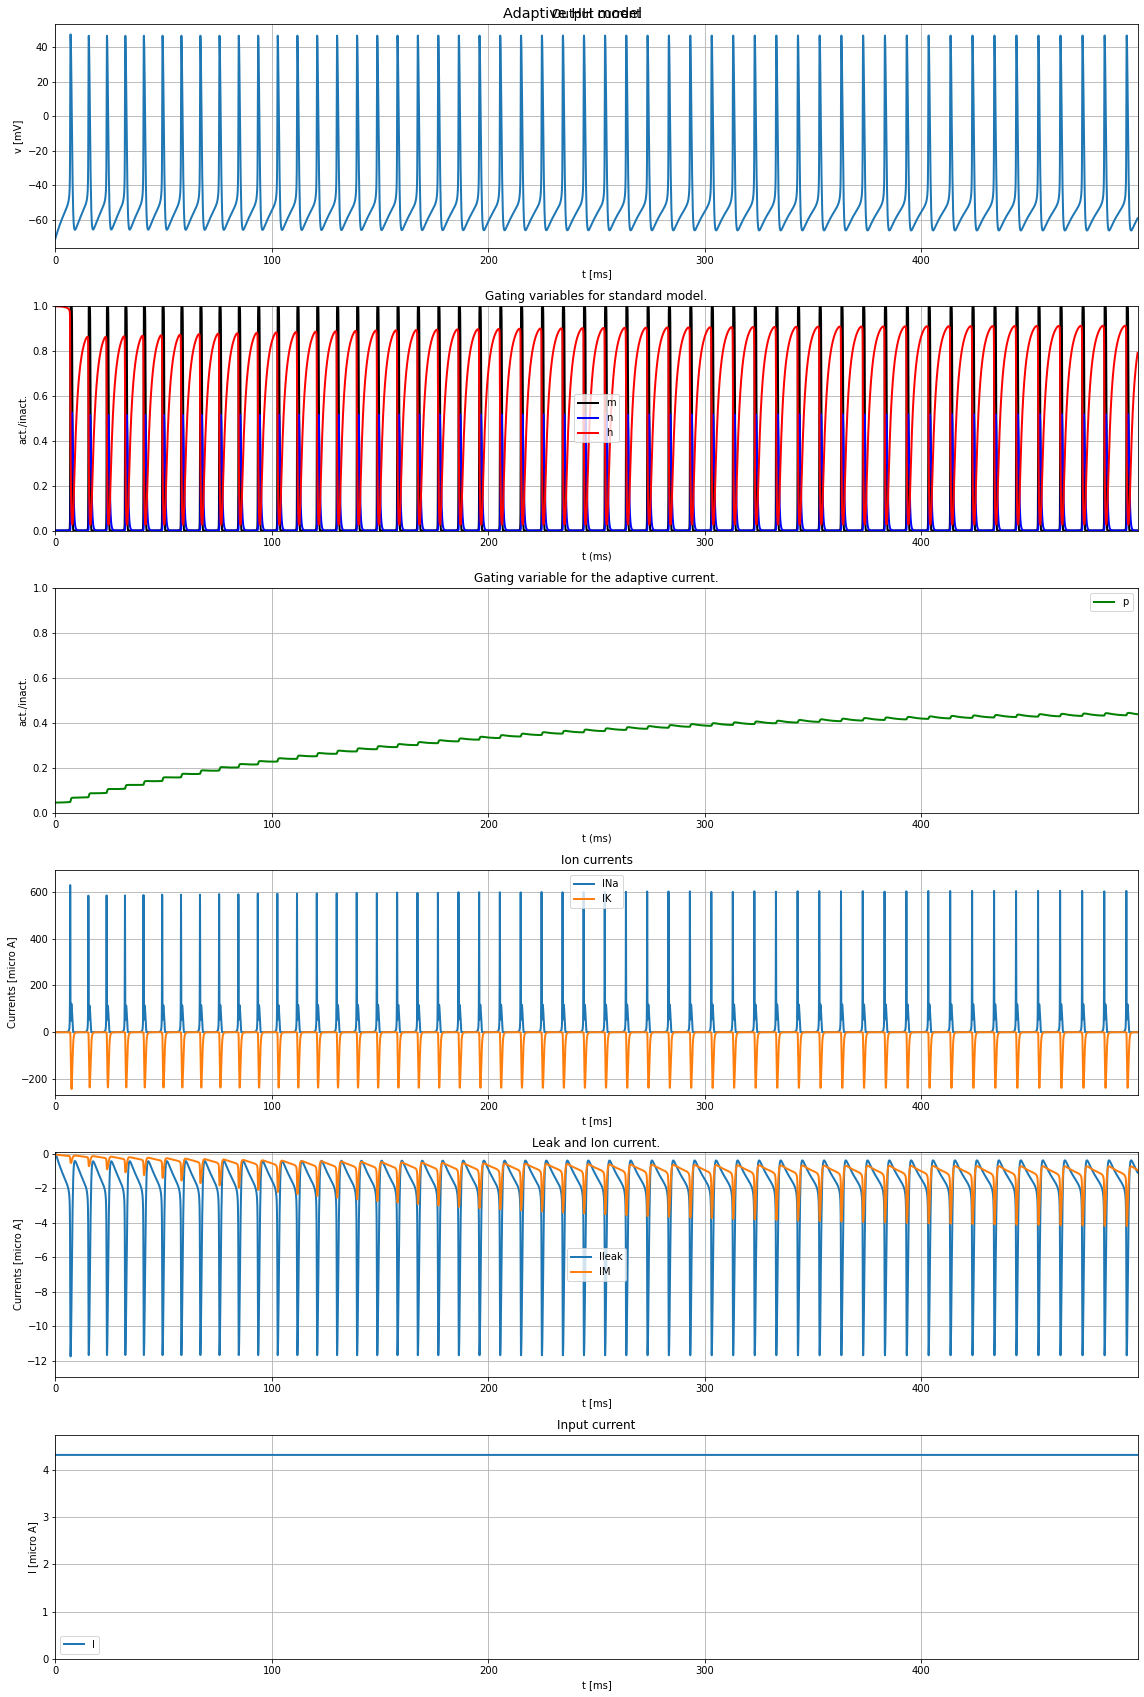

nr of spikes: 52
mean ISI: 0.009568235294117648
ISI variance: 3.02477277970012e-07
spike freq: 104.51248001967292
spike times: too many values
ISI: too many values


In [58]:
current = input_factory.get_step_current(0, 500, b2.ms, I_ext)
state_monitor = simulate_adaptive_HH_neuron(current, 500 * b2.ms, init_dict=adaptive_init)
plot_data(state_monitor, title="Adaptive HH model")
spike_times, ISI, mean_isi, spike_freq, var_isi = pretty_print_spike_train_stats(state_monitor, 30*b2.mV)

nr of spikes: 229


(<AxesSubplot:ylabel='Input current [A] \n min: 4.315048940232234e-06 \nmax: 4.315048940232234e-06'>,
 <AxesSubplot:xlabel='t [ms]', ylabel='membrane voltage [mV]\n min: -0.07540980857972836\n max: 0.02970344220007675'>)

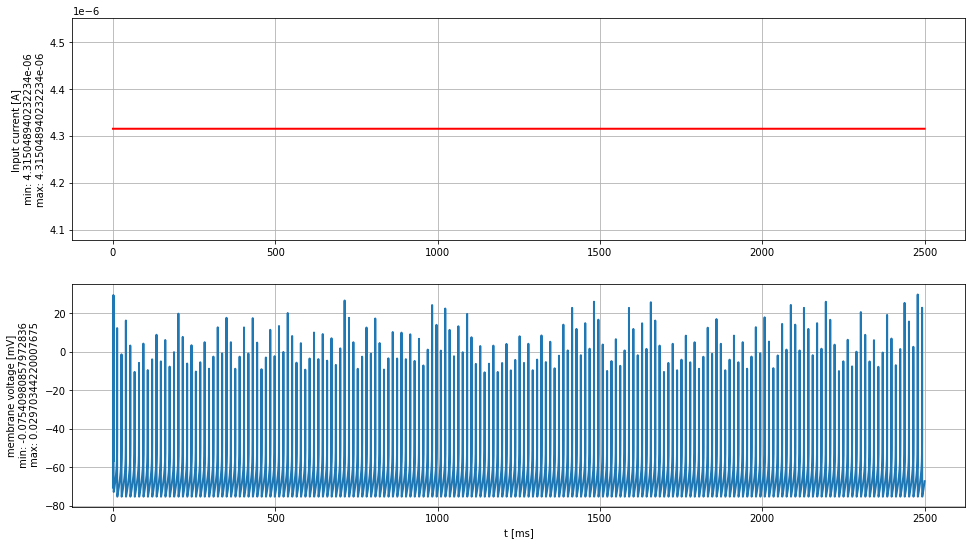

In [59]:
current = input_factory.get_step_current(0, 2500, b2.ms, I_ext)
state_monitor, spike_monitor = AdEx.simulate_AdEx_neuron( tau_m=0.063*b2.ms,
                                        R=0.099527 *b2.Mohm, v_rest=-70.60*b2.mV , v_rheobase=-56*b2.mV, a=-29920 * b2.nS, v_spike=30*b2.mV, delta_T=14.6*b2.mV ,
                                        b=100000 * b2.pA, tau_w=600*b2.ms, v_reset= -57 * b2.mV,
                                        I_stim=current,simulation_time=2500 * b2.ms)
print("nr of spikes: {}".format(spike_monitor.count[0]))
fig,ax = plt.subplots(figsize=(16,9))
plot_tools.plot_voltage_and_current_traces(state_monitor, current)

In [60]:
current = input_factory.get_step_current(0, 2500, b2.ms, I_ext)
state_monitor = simulate_adaptive_HH_neuron(current, 2500 * b2.ms, init_dict=adaptive_init)
spike_times, ISI, mean_isi, spike_freq, var_isi = pretty_print_spike_train_stats(state_monitor, 30*b2.mV)

nr of spikes: 245
mean ISI: 0.01019032786885246
ISI variance: 1.661556302069335e-07
spike freq: 98.13226942938498
spike times: too many values
ISI: too many values
